In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import seaborn as sns
import swifter
import json
import itertools
from pprint import pprint

# Functions

In [2]:
# Find files
# This function input the path of experiment directory and output a list of device directories of the experiment directory.
def find_device_under_exp(exp_dir_path):
    dev_dir_list = sorted([os.path.join(exp_dir_path, d) for d in os.listdir(exp_dir_path) if d.startswith('qc') or d.startswith('sm')])
    return dev_dir_list

def find_trace_under_device(dev_dir_path):
    trace_dir_list = sorted([os.path.join(dev_dir_path, d) for d in os.listdir(dev_dir_path)])
    return trace_dir_list

# Statistic functions
# This function input the file path of the loss_latency csv and output the loss and excessive latency rate.
def count_loss_excl_rate(file_path):

    df = pd.read_csv (file_path)

    # Total package in the experiment
    total_pkg_num = len(df)

    # Loss calculate
    loss_cond = df['lost'] == True
    loss_num = loss_cond.value_counts().loc[True]
    loss_rate = loss_num/total_pkg_num

    # Excexxive latency calculate
    exc_lat = 0.1
    excl_cond = df[loss_cond==False]['latency'] > exc_lat
    excl_num = excl_cond.value_counts().loc[True]
    excl_rate = excl_num/total_pkg_num

    return loss_rate, excl_rate

# This function input two file paths of the loss_latency csv and output the 
# loss and excessive latency rate of dual radio condition.
def count_loss_excl_rate_dual(file_path1, file_path2):

    df1 = pd.read_csv(file_path1)
    df2 = pd.read_csv(file_path2)

    start_seq = df1['seq'].iloc[0] if df1['seq'].iloc[0] >=  df2['seq'].iloc[0] else df2['seq'].iloc[0]
    end_seq = df1['seq'].iloc[-1] if df1['seq'].iloc[-1] <=  df2['seq'].iloc[-1] else df2['seq'].iloc[-1]
    total_pkg_num = end_seq - start_seq + 1

    cond1 = (df1['seq'] >= start_seq) & (df1['seq'] <= end_seq)
    df1 = df1[cond1]
    df1 = df1.reset_index(drop=True)
    cond2 = (df2['seq'] >= start_seq) & (df2['seq'] <= end_seq)
    df2 = df2[cond2]
    df2 = df2.reset_index(drop=True)

    # Loss calculate for dual radios redundant packets.
    loss_cond = (df1['lost'] == True) & (df2['lost'] == True)
    try: loss_num = loss_cond.value_counts().loc[True]
    except: loss_num = 0
    loss_rate = loss_num/total_pkg_num

    # Excexxive latency calculate for dual radios redundant packets.
    exc_lat = 0.1   
    excl_cond1 = df1[(loss_cond==False)]['latency'] > exc_lat
    excl_cond2 = df2[(loss_cond==False)]['latency'] > exc_lat
    excl_cond = (excl_cond1 == True) & (excl_cond2 == True)
    try: excl_num = excl_cond.value_counts().loc[True]
    except: excl_num = 0
    excl_rate = excl_num/total_pkg_num

    return loss_rate, excl_rate

# Convenience instance
class EXPERIMENT():
    def __init__(self, exp_dir_path, settings):
        self.path = exp_dir_path
        self.settings = json.loads(settings)
    def __repr__(self):
        return f'EXP: {self.path} -> {self.settings}'

# Main

In [3]:
# This place give a XXXX-XX-XX.md file and find the experiment directory path
# and the corresponding band settings. It will be presented by a list of special
# instance EXPERIMENTs.

md_file_path = '/Users/jackbedford/Desktop/MOXA/Code/data/2023-06-12/2023-06-12.md'
date_dir_path = os.path.dirname(md_file_path)
EXPs = []

with open(md_file_path) as f:

    exp = f.readline()[:-1]
    settings = f.readline()[:-1]

    while exp != '#endif' and settings:
        E = EXPERIMENT(os.path.join(date_dir_path, exp), settings)
        EXPs.append(E)
        exp = f.readline()[:-1]
        settings = f.readline()[:-1]

EXPs

[EXP: /Users/jackbedford/Desktop/MOXA/Code/data/2023-06-12/Bandlock_8_Schemes_Phone -> {'sm00': 'B3B7B8', 'sm01': 'B3', 'sm02': 'B7', 'sm03': 'B8', 'sm04': 'B3B7', 'sm05': 'B3B8', 'sm06': 'B7B8', 'sm07': 'LTE'}]

## Single Radio Analysis

In [4]:
# Here is the example of given a experiment directory and plot the 
# box plot of DL/UL loss/excessive latency. 

# Still need to revise here.
EXP = EXPs[0]
exp_dir_path = EXP.path
settings = EXP.settings 

dev_dir_list = find_device_under_exp(exp_dir_path)
dev_metric_dict = {}

for dev_dir_path in dev_dir_list:

    dev = dev_dir_path.split('/')[-1]
    metrics_dict = {}
    trace_dir_list = find_trace_under_device(dev_dir_path)
    dl_loss_rates, dl_excl_rates = [], []    
    ul_loss_rates, ul_excl_rates = [], []

    for trace_dir_path in trace_dir_list:

        dl_file_path = os.path.join(trace_dir_path, 'data/udp_dnlk_loss_latency.csv')
        ul_file_path = os.path.join(trace_dir_path, 'data/udp_uplk_loss_latency.csv')

        dl_loss_rate, dl_excl_rate = count_loss_excl_rate(dl_file_path)
        ul_loss_rate, ul_excl_rate = count_loss_excl_rate(ul_file_path)

        dl_loss_rates.append(dl_loss_rate); dl_excl_rates.append(dl_excl_rate)
        ul_loss_rates.append(ul_loss_rate); ul_excl_rates.append(ul_excl_rate)
    
    metrics_dict['dl_loss'] = dl_loss_rates
    metrics_dict['dl_excl'] = dl_excl_rates
    metrics_dict['ul_loss'] = ul_loss_rates
    metrics_dict['ul_excl'] = ul_excl_rates

    dev_metric_dict[dev] = metrics_dict

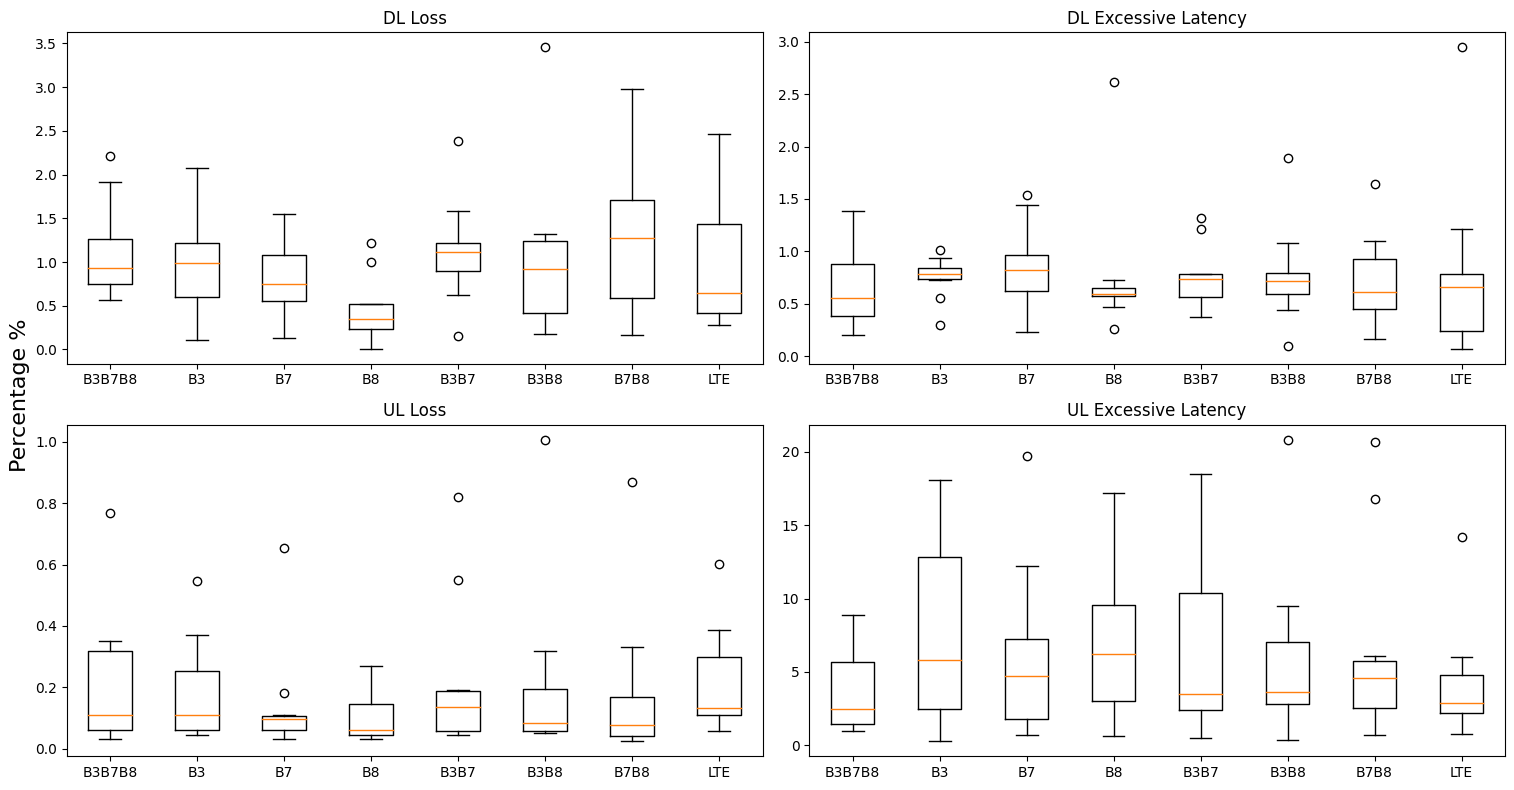

In [5]:
fig, axes = plt.subplots(2,2, figsize=(15, 8))
dl_loss_boxes, dl_excl_boxes = [], []
ul_loss_boxes, ul_excl_boxes = [], []
labels = [settings[k] for k in list(dev_metric_dict.keys())]

for k, v in dev_metric_dict.items():

    dl_loss_box = [value*100 for value in dev_metric_dict[k]['dl_loss'] ] 
    dl_excl_box = [value*100 for value in dev_metric_dict[k]['dl_excl'] ] 
    ul_loss_box = [value*100 for value in dev_metric_dict[k]['ul_loss'] ]
    ul_excl_box = [value*100 for value in dev_metric_dict[k]['ul_excl'] ]

    dl_loss_boxes.append(dl_loss_box)
    dl_excl_boxes.append(dl_excl_box)
    ul_loss_boxes.append(ul_loss_box)
    ul_excl_boxes.append(ul_excl_box)

axes[0][0].boxplot(dl_loss_boxes, labels=labels)
axes[0][0].set_title('DL Loss')
axes[0][1].boxplot(dl_excl_boxes, labels=labels)
axes[0][1].set_title('DL Excessive Latency')
axes[1][0].boxplot(ul_loss_boxes, labels=labels)
axes[1][0].set_title('UL Loss')
axes[1][1].boxplot(ul_excl_boxes, labels=labels)
axes[1][1].set_title('UL Excessive Latency')

# fig.text(0.5, 0.0, 'common xlabel', ha='center', va='center', fontsize=16)
fig.text(0.0, 0.5, 'Percentage %', ha='center', va='center', rotation='vertical', fontsize=16)

plt.tight_layout()
plt.show()

In [6]:
# This place given an experiment directory, plot bar plot of UL/DL loss/excessive latency rate  
# of all the traces. You must run the above box plot code to make this place work.

dl_loss_bars, dl_excl_bars = [], []
ul_loss_bars, ul_excl_bars = [], []
trace_num = len(trace_dir_list)

for i in range(trace_num):

    dl_loss_bar = [dev_metric_dict[k]['dl_loss'][i]*100 for k in dev_metric_dict.keys()]
    dl_excl_bar = [dev_metric_dict[k]['dl_excl'][i]*100 for k in dev_metric_dict.keys()]
    ul_loss_bar = [dev_metric_dict[k]['ul_loss'][i]*100 for k in dev_metric_dict.keys()]
    ul_excl_bar = [dev_metric_dict[k]['ul_excl'][i]*100 for k in dev_metric_dict.keys()]

    dl_loss_bars.append(dl_loss_bar)
    dl_excl_bars.append(dl_excl_bar)
    ul_loss_bars.append(ul_loss_bar)
    ul_excl_bars.append(ul_excl_bar) 

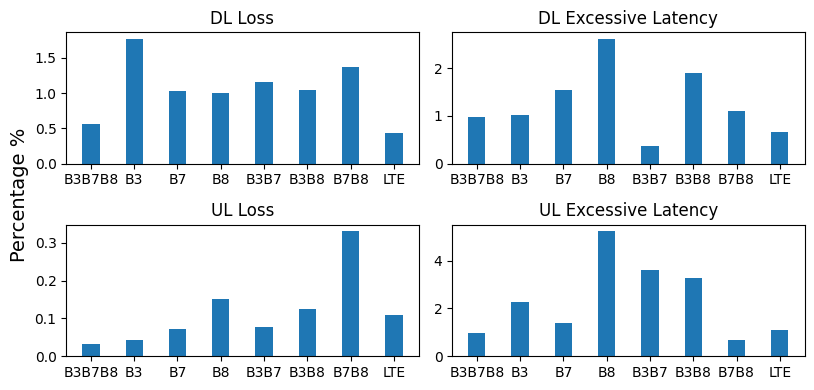

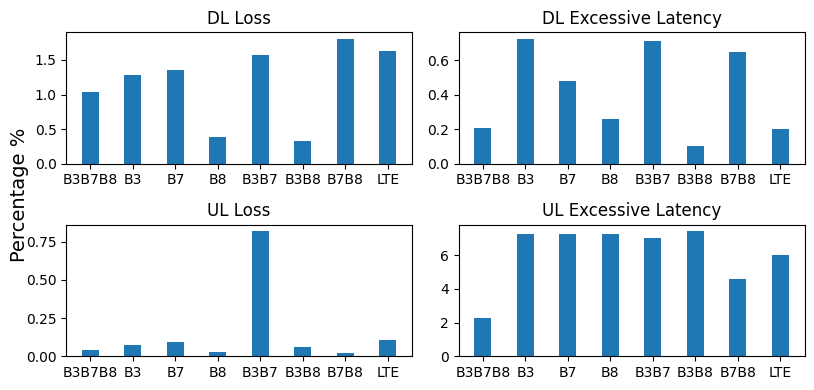

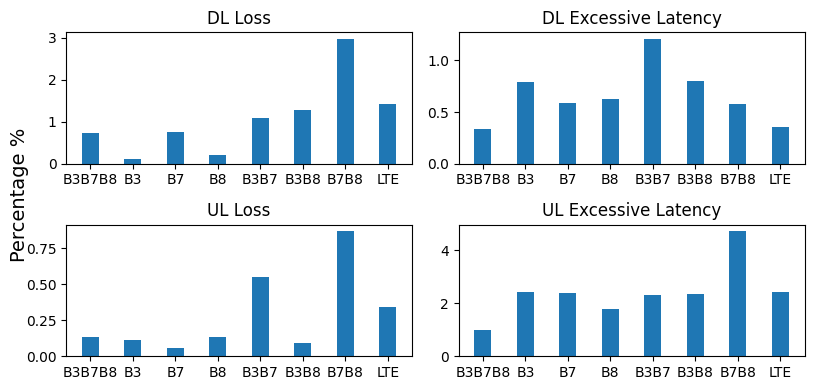

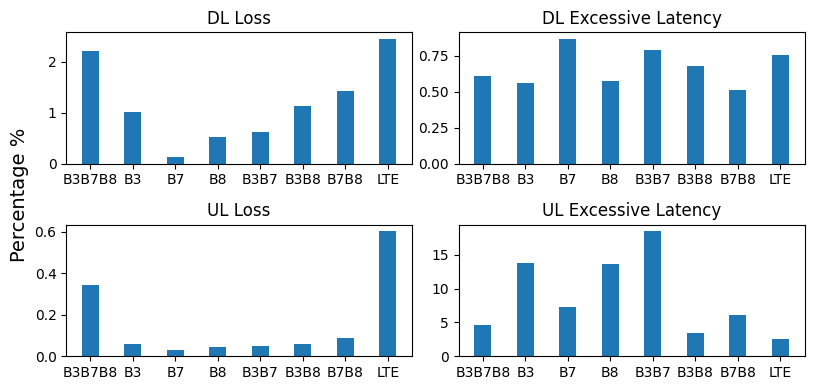

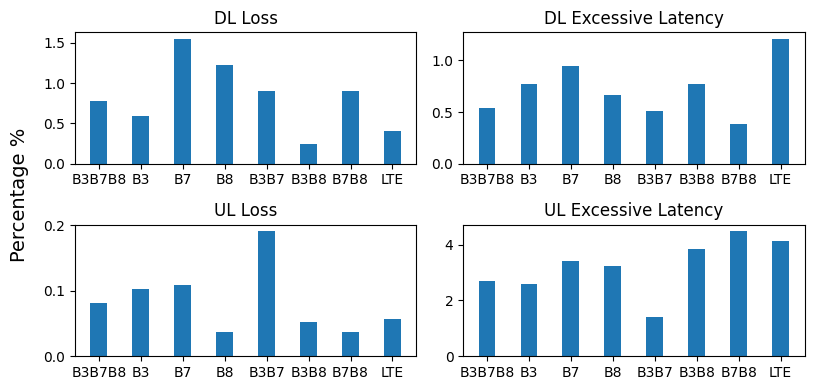

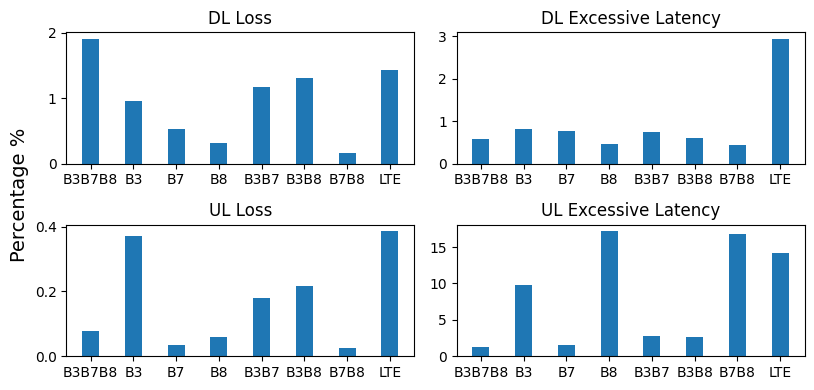

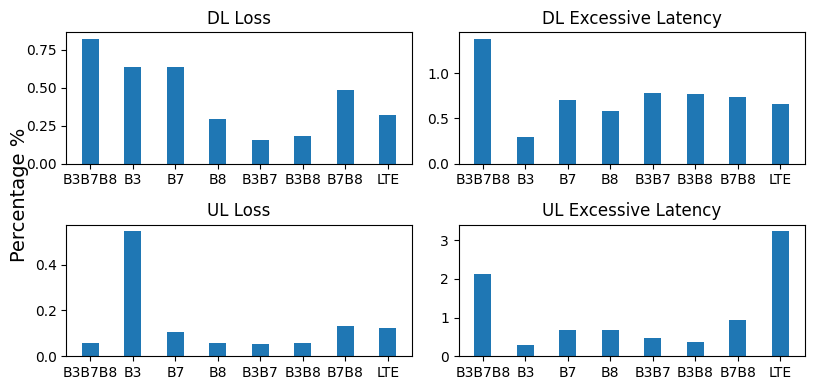

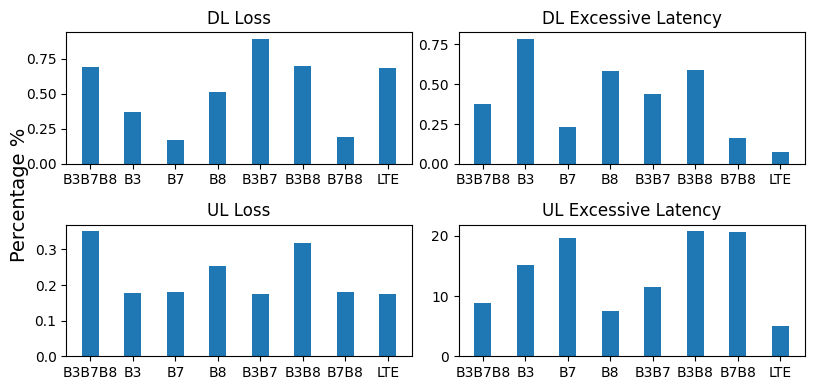

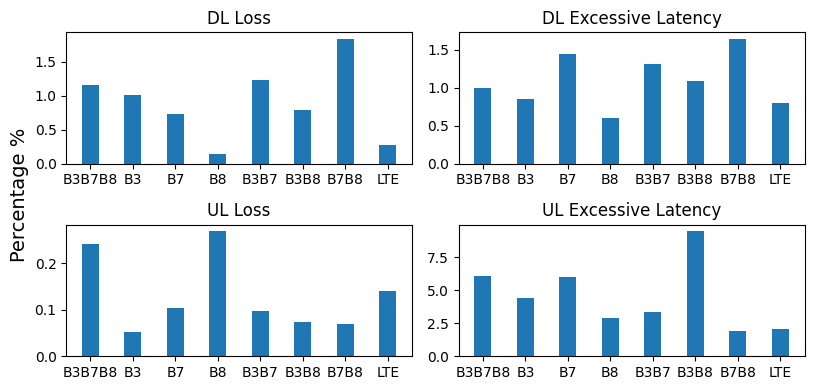

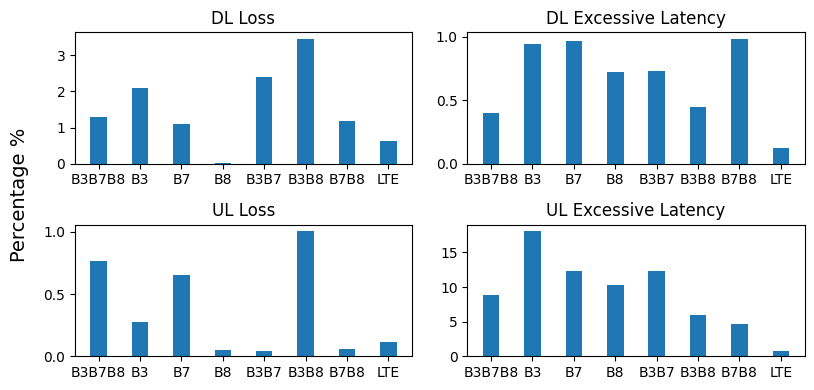

In [7]:
for i in range(trace_num):
    fig, axes = plt.subplots(2,2, figsize=(8, 4))

    axes[0][0].bar(labels, dl_loss_bars[i], width=0.4)
    axes[0][0].set_title('DL Loss')
    axes[0][1].bar(labels, dl_excl_bars[i], width=0.4)
    axes[0][1].set_title('DL Excessive Latency')
    axes[1][0].bar(labels, ul_loss_bars[i], width=0.4)
    axes[1][0].set_title('UL Loss')
    axes[1][1].bar(labels, ul_excl_bars[i], width=0.4)
    axes[1][1].set_title('UL Excessive Latency')

    fig.text(0.0, 0.5, 'Percentage %', ha='center', va='center', rotation='vertical', fontsize=14)
    
    plt.tight_layout()
    plt.show()


## Dual Radio Analysis

In [7]:
# This place calculate the dual redio performance 
# given a experiment directory.

# Still need to revise here.
EXP = EXPs[0]
exp_dir_path = EXP.path
settings = EXP.settings 

dev_dir_list = find_device_under_exp(exp_dir_path)
comb = itertools.combinations(dev_dir_list, 2)
comb_metric_dict = {}

for dev_dir_path1, dev_dir_path2 in comb:
    
    dev1 = dev_dir_path1.split('/')[-1]
    dev2 = dev_dir_path2.split('/')[-1]
    
    print(dev1, dev2)
    trace_dir_list1 = find_trace_under_device(dev_dir_path1)
    trace_dir_list2 = find_trace_under_device(dev_dir_path2)
    metrics_dict = {}

    dl_loss_rates, dl_excl_rates = [], []    
    ul_loss_rates, ul_excl_rates = [], []
    
    for trace_dir_path1, trace_dir_path2 in zip(trace_dir_list1, trace_dir_list2):
        dl_file_path1 = os.path.join(trace_dir_path1, 'data/udp_dnlk_loss_latency.csv')
        ul_file_path1 = os.path.join(trace_dir_path1, 'data/udp_uplk_loss_latency.csv')
        dl_file_path2 = os.path.join(trace_dir_path2, 'data/udp_dnlk_loss_latency.csv')
        ul_file_path2 = os.path.join(trace_dir_path2, 'data/udp_uplk_loss_latency.csv')

        dl_loss_rate, dl_excl_rate = count_loss_excl_rate_dual(dl_file_path1, dl_file_path2)
        ul_loss_rate, ul_excl_rate = count_loss_excl_rate_dual(ul_file_path1, ul_file_path2)

        dl_loss_rates.append(dl_loss_rate); dl_excl_rates.append(dl_excl_rate)
        ul_loss_rates.append(ul_loss_rate); ul_excl_rates.append(ul_excl_rate)
    
    metrics_dict['dl_loss'] = dl_loss_rates
    metrics_dict['dl_excl'] = dl_excl_rates
    metrics_dict['ul_loss'] = ul_loss_rates
    metrics_dict['ul_excl'] = ul_excl_rates

    comb_metric_dict[f'{dev1}+{dev2}'] = metrics_dict

sm00 sm01
sm00 sm02
sm00 sm03
sm00 sm04
sm00 sm05
sm00 sm06
sm00 sm07
sm01 sm02
sm01 sm03
sm01 sm04
sm01 sm05
sm01 sm06
sm01 sm07
sm02 sm03
sm02 sm04
sm02 sm05
sm02 sm06
sm02 sm07
sm03 sm04
sm03 sm05
sm03 sm06
sm03 sm07
sm04 sm05
sm04 sm06
sm04 sm07
sm05 sm06
sm05 sm07
sm06 sm07


In [8]:
# This place calculate the average performance of an 
# experiment setting and plot the heatmap below.
 
num_of_devs = len(settings)
data_dl_loss = np.zeros((num_of_devs, num_of_devs))
data_dl_excl = np.zeros((num_of_devs, num_of_devs))
data_ul_loss = np.zeros((num_of_devs, num_of_devs))
data_ul_excl = np.zeros((num_of_devs, num_of_devs))

keys = list(comb_metric_dict.keys())
count = 0

for i in range(num_of_devs):
    for j in range(i+1, num_of_devs):

        k = keys[count]
        
        dl_loss = np.mean(comb_metric_dict[k]['dl_loss'])
        dl_excl = np.mean(comb_metric_dict[k]['dl_excl'])
        ul_loss = np.mean(comb_metric_dict[k]['ul_loss'])
        ul_excl = np.mean(comb_metric_dict[k]['ul_excl'])

        data_dl_loss[i, j] = dl_loss*100
        data_dl_excl[i, j] = dl_excl*100
        data_ul_loss[i, j] = ul_loss*100
        data_ul_excl[i, j] = ul_excl*100

        count += 1


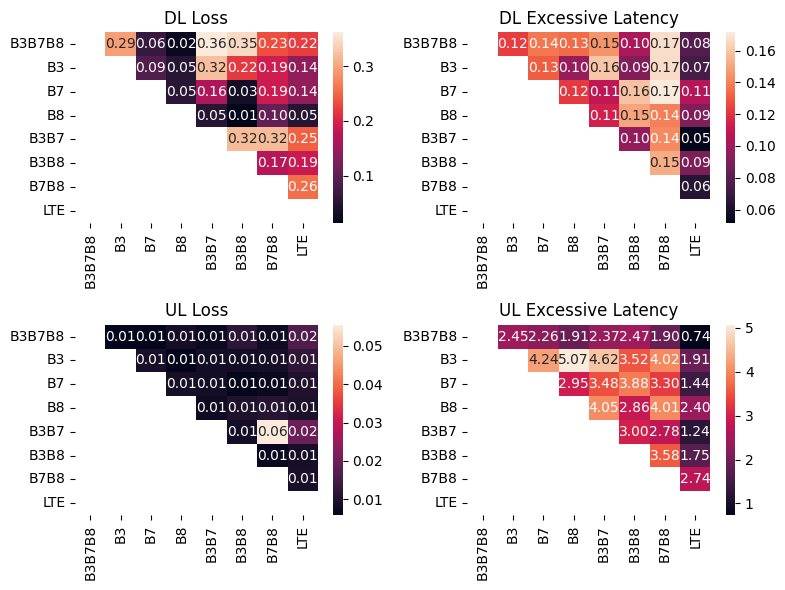

In [9]:
fig, axes = plt.subplots(2,2, figsize=(8,6))

labels = list(settings.values())
mask = np.tri(data_dl_loss.shape[0], dtype=bool, k=0)

sns.heatmap(data_dl_loss, ax=axes[0,0], mask=mask, annot=True, fmt=".2f")
axes[0,0].set_xticklabels(labels, rotation=90)
axes[0,0].set_yticklabels(labels, rotation=0)
axes[0,0].set_title('DL Loss')
sns.heatmap(data_dl_excl, ax=axes[0,1], mask=mask, annot=True, fmt=".2f")
axes[0,1].set_xticklabels(labels, rotation=90)
axes[0,1].set_yticklabels(labels, rotation=0)
axes[0,1].set_title('DL Excessive Latency')
sns.heatmap(data_ul_loss, ax=axes[1,0], mask=mask, annot=True, fmt=".2f")
axes[1,0].set_xticklabels(labels, rotation=90)
axes[1,0].set_yticklabels(labels, rotation=0)
axes[1,0].set_title('UL Loss')
sns.heatmap(data_ul_excl, ax=axes[1,1], mask=mask, annot=True, fmt=".2f")
axes[1,1].set_xticklabels(labels, rotation=90)
axes[1,1].set_yticklabels(labels, rotation=0)
axes[1,1].set_title('UL Excessive Latency')

plt.tight_layout()
plt.show()

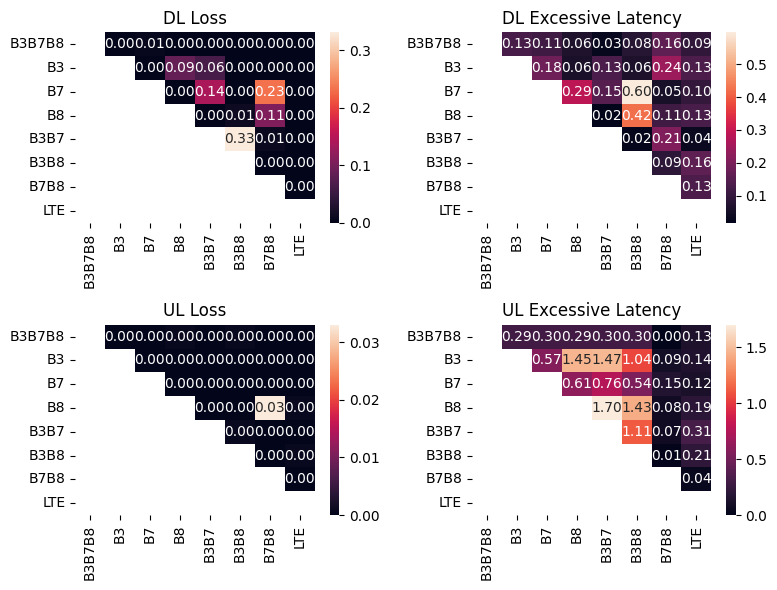

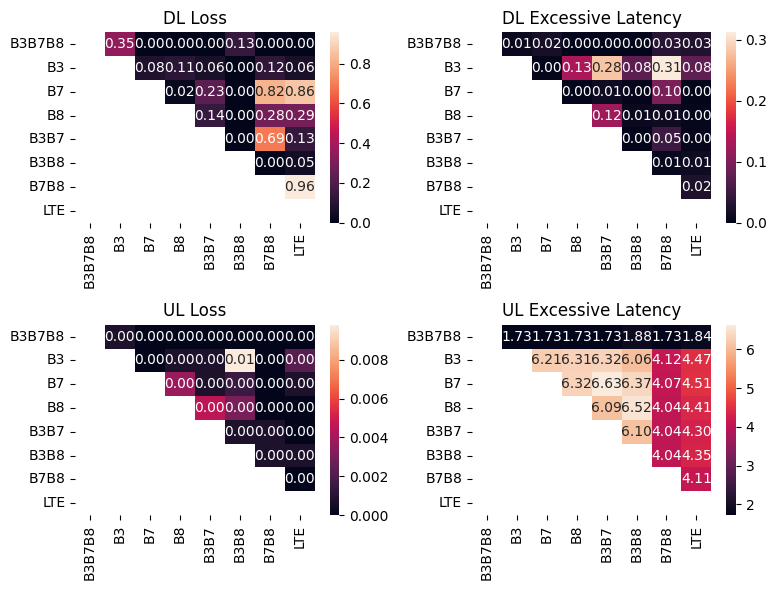

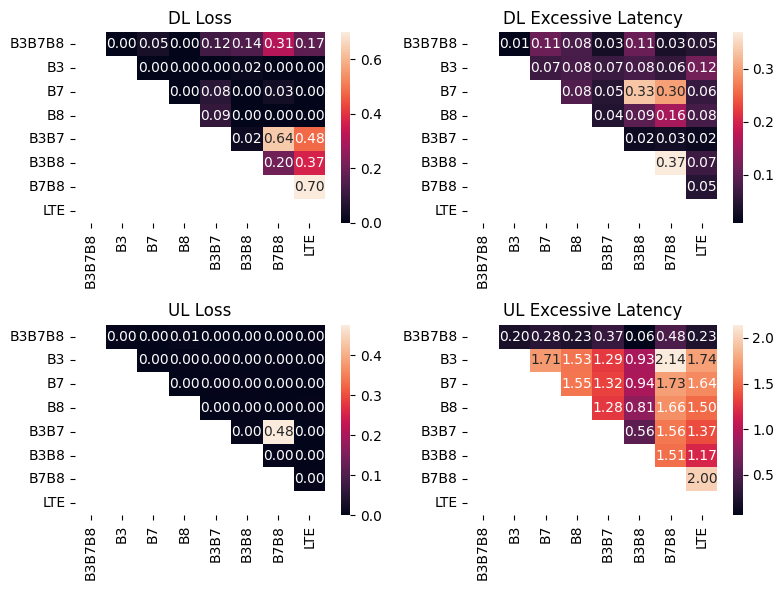

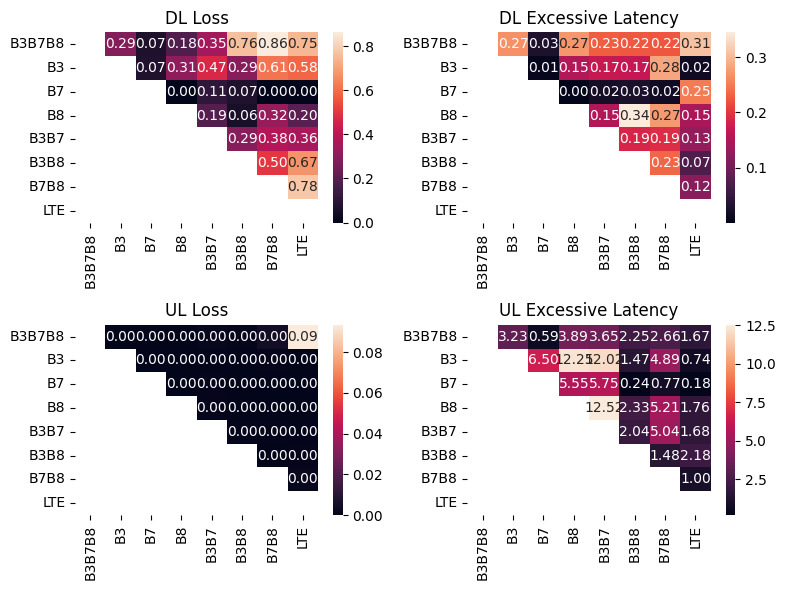

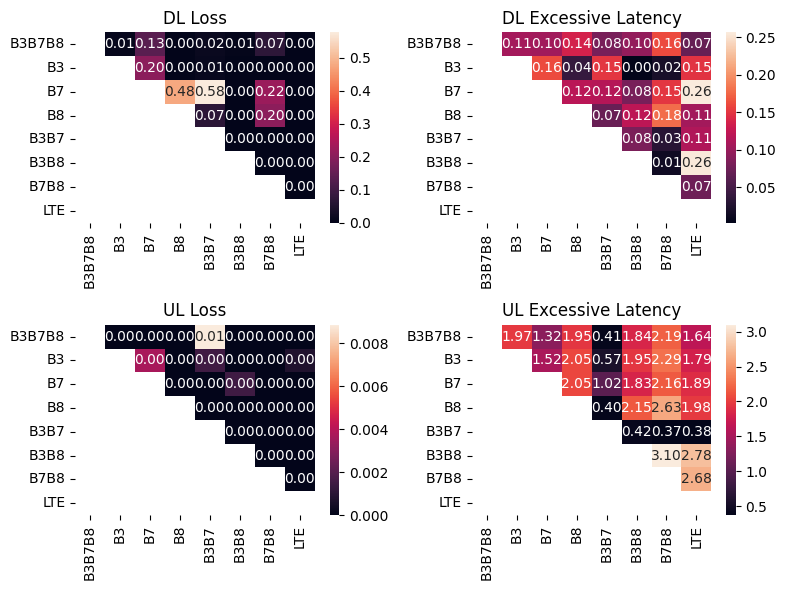

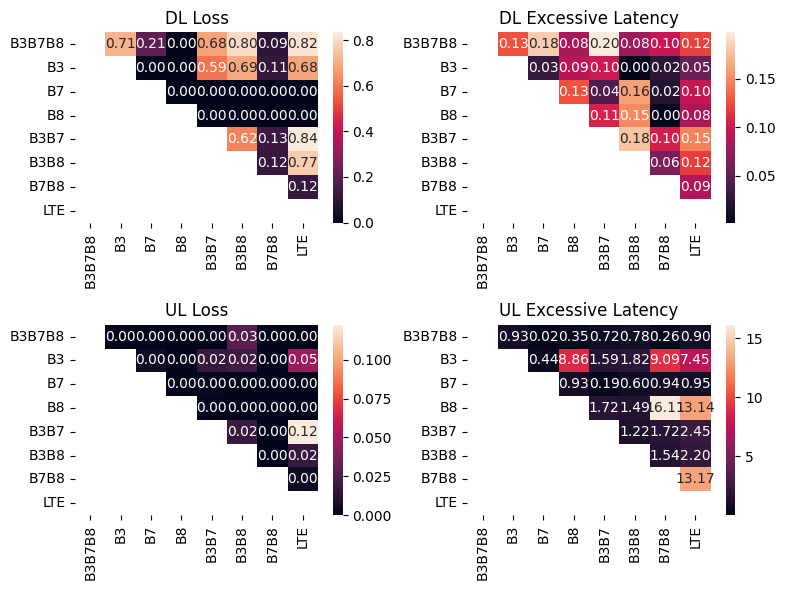

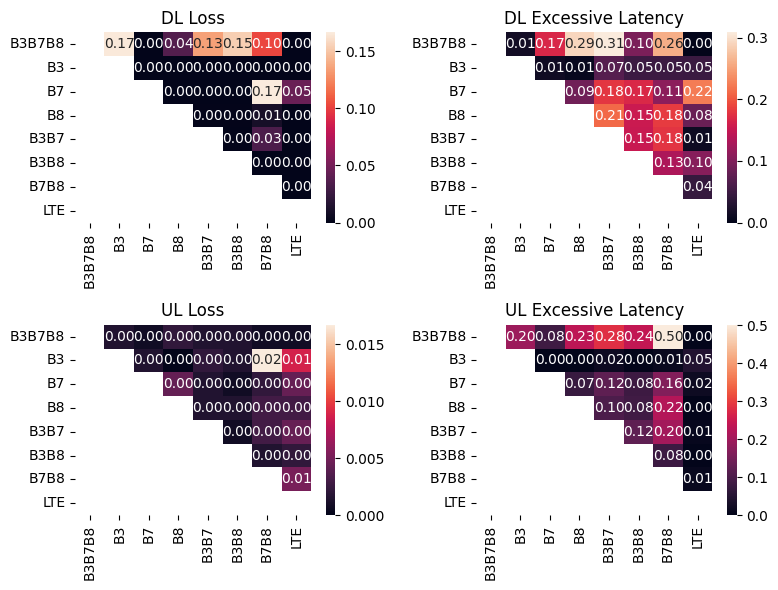

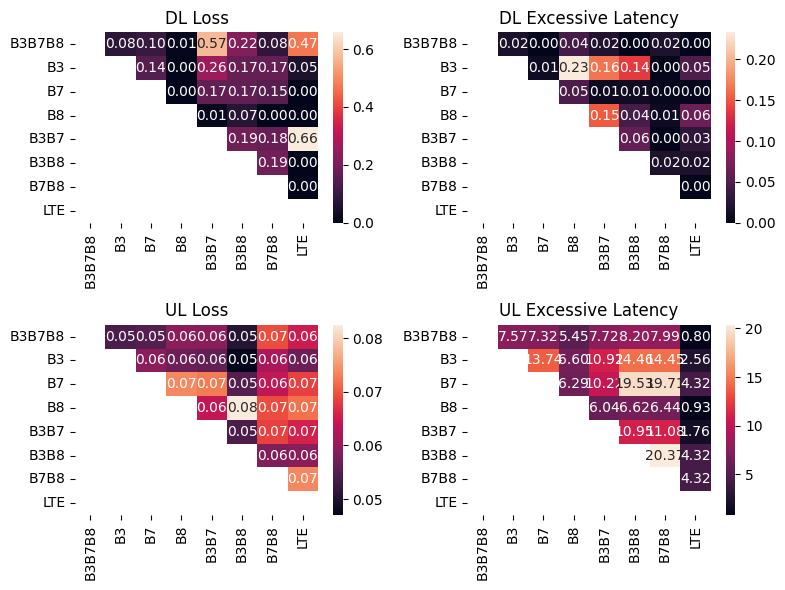

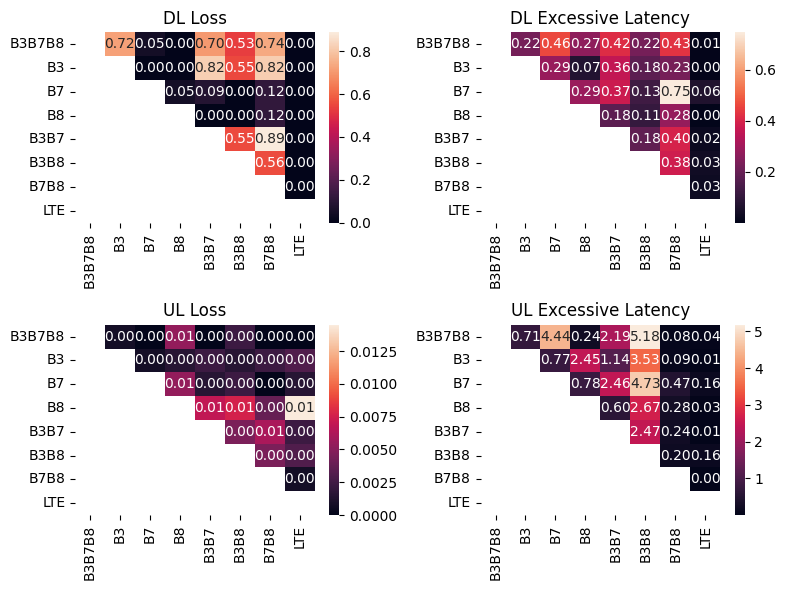

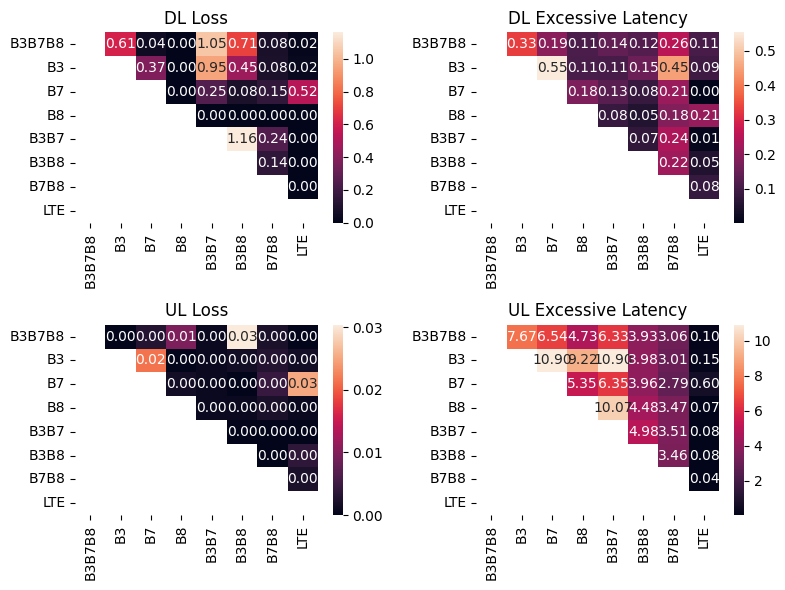

In [10]:
# This place plot the heatmap of every trace
# of an experiment.
 
num_of_devs = len(settings)
keys = list(comb_metric_dict.keys())

for t in range(trace_num):
    
    data_dl_loss = np.zeros((num_of_devs, num_of_devs))
    data_dl_excl = np.zeros((num_of_devs, num_of_devs))
    data_ul_loss = np.zeros((num_of_devs, num_of_devs))
    data_ul_excl = np.zeros((num_of_devs, num_of_devs))

    count = 0

    for i in range(num_of_devs):
        for j in range(i+1, num_of_devs):

            k = keys[count]
            
            dl_loss = comb_metric_dict[k]['dl_loss'][t]
            dl_excl = comb_metric_dict[k]['dl_excl'][t]
            ul_loss = comb_metric_dict[k]['ul_loss'][t]
            ul_excl = comb_metric_dict[k]['ul_excl'][t]

            data_dl_loss[i, j] = dl_loss*100
            data_dl_excl[i, j] = dl_excl*100
            data_ul_loss[i, j] = ul_loss*100
            data_ul_excl[i, j] = ul_excl*100

            count += 1

    fig, axes = plt.subplots(2,2, figsize=(8,6))

    labels = list(settings.values())
    mask = np.tri(data_dl_loss.shape[0], dtype=bool, k=0)

    sns.heatmap(data_dl_loss, ax=axes[0,0], mask=mask, annot=True, fmt=".2f")
    axes[0,0].set_xticklabels(labels, rotation=90)
    axes[0,0].set_yticklabels(labels, rotation=0)
    axes[0,0].set_title('DL Loss')
    sns.heatmap(data_dl_excl, ax=axes[0,1], mask=mask, annot=True, fmt=".2f")
    axes[0,1].set_xticklabels(labels, rotation=90)
    axes[0,1].set_yticklabels(labels, rotation=0)
    axes[0,1].set_title('DL Excessive Latency')
    sns.heatmap(data_ul_loss, ax=axes[1,0], mask=mask, annot=True, fmt=".2f")
    axes[1,0].set_xticklabels(labels, rotation=90)
    axes[1,0].set_yticklabels(labels, rotation=0)
    axes[1,0].set_title('UL Loss')
    sns.heatmap(data_ul_excl, ax=axes[1,1], mask=mask, annot=True, fmt=".2f")
    axes[1,1].set_xticklabels(labels, rotation=90)
    axes[1,1].set_yticklabels(labels, rotation=0)
    axes[1,1].set_title('UL Excessive Latency')

    plt.tight_layout()
    plt.show()

In [ ]:
df1 = pd.read_csv(dl_file_path1)

In [ ]:
dir_path = '/home/wmnlab/D/database/2023-06-12/Bandlock_8_Schemes_Phone/combo'
L = sorted([os.path.join(dir_path, x, 'udp_dnlk_combo_statistics.csv') for x in os.listdir(dir_path)])

for f in L:
    df = pd.read_csv(f)
    print(df['lost_All+B3'].item())